## Chronos_Fx-Quarterly_panel


In [ ]:
pip install chronos-forecasting

In [ ]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'SP500', 'Q', 'StoxEurope', 'd_pi', 'dI_t', 'VIX', 'Brent', 'OBX_Energy', 'OSEBX']


`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!



Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK – past-only covariates) ===
Observations: 103
RMSE (level): 0.206174
MAE  (level): 0.142836
Directional accuracy: 79/102 (77.5%)

=== Diebold–Mariano vs Random Walk (past-only covariates) ===
Loss: MSE | horizon h=1
DM-statistic: -1.2247
p-value     : 0.2207


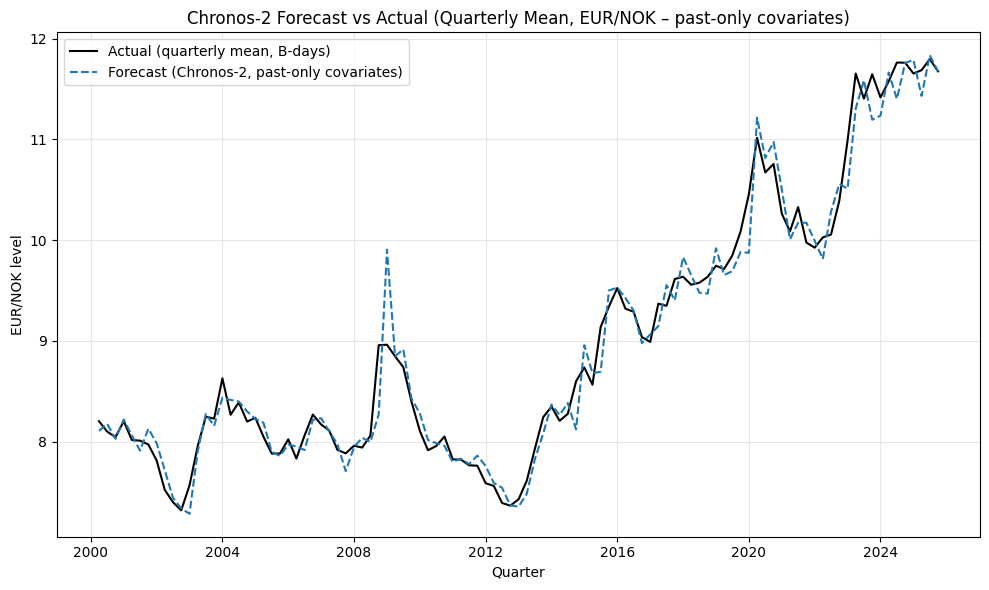

Saved: Chronos2Q_daily_pastcov.png
Saved: Chronos2Q_daily_pastcov.pdf


In [3]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (quarterly, levels) with daily data
Past-covariate setup:
  - Target: EUR_NOK (single item_id)
  - Covariates (past-only): all other variables incl. macros and financial series
  - No future_df passed to Chronos -> no leakage, all features treated as past covariates
  - Cut: last business day of previous quarter (based on EUR_NOK B-days)
  - Forecast: next calendar quarter at daily frequency,
              aggregated to quarterly mean over business days (EUR/NOK only)
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # from chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    q_freq: str = "Q-DEC"      # quarterly evaluation
    min_hist_days: int = 40    # minimum number of daily obs before first forecast
    max_context: int = 2048
    max_horizon: int = 128     # must exceed longest quarter (~92 days); 128 is a safe margin
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2Q_daily_pastcov.png"
    fig_pdf: str = "Chronos2Q_daily_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# Alle variabler som skal brukes som past covariates (alt unntatt target)
COVARIATE_COLS = [
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
    "Q",
    "d_pi",
    "dI_t",
]

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading: daily EUR_NOK (B + D) + wide DF_d with covariates
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV with columns:
      Date, EUR_NOK, Q, d_pi, dI_t, Brent, VIX,
      StoxEurope, SP500, OSEBX, OBX_Energy

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (for cuts and quarterly ground truth)
      DF_d : daily (D) wide DataFrame with TARGET_SERIES + COVARIATE_COLS
             (calendar days, forward-filled)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {
        "Date", "EUR_NOK", "Q", "d_pi", "dI_t",
        "Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"
    }
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", "EUR_NOK"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types for all non-date columns
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["EUR_NOK"])

    # Business-day EUR_NOK (ground truth / aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF_d (calendar days, forward-filled) for target + covariates
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Build single-series context with past-only covariates
# -----------------------------
def make_context_with_past_cov(df_wide: pd.DataFrame) -> pd.DataFrame:
    """
    Create Chronos-2 context df for a single target series with covariates.

    Output columns:
      ['item_id','timestamp','target', <COVARIATE_COLS>]
    """
    ctx = pd.DataFrame({
        "timestamp": df_wide.index,
        "item_id": TARGET_SERIES,
        "target": df_wide[TARGET_SERIES].values,
    })
    for c in COVARIATE_COLS:
        ctx[c] = df_wide[c].values
    return ctx.sort_values("timestamp")

# -----------------------------
# Chronos-2 model builder (single item, all covariates past-only)
# -----------------------------
def build_model_chronos2(
    max_context: int,
    horizon_len: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """
    Build a Chronos-2 forecasting function for EUR_NOK with past-only covariates.

    Returns:
      forecast_fn(context_df, H) -> DataFrame with columns:
        ['item_id', 'timestamp', 'y_pred']
    """
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install a CUDA build of PyTorch and a recent NVIDIA driver.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values(["item_id", "timestamp"]) if "item_id" in df.columns else df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Chronos2 predict_df: unsupported schema. Columns={list(df.columns)}.")

        keep_cols = [c for c in ["item_id", "timestamp", "y_pred"] if c in df.columns]
        return df[keep_cols].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.copy()

        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                # Ingen future_df -> alle ekstra kolonner behandles som past covariates
            )

        return _extract_median(pred)

    return _forecast

# -----------------------------
# Quarterly walk-forward on daily data, EUR_NOK eval
# -----------------------------
def walk_forward_chronos2_quarterly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:
    """
    Quarterly walk-forward evaluation using single-series context with past-only covariates.
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue
        y_true = float(S_b.loc[idx_q_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_context_with_past_cov(hist_wide)

        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy()

        if "timestamp" in df_fx.columns:
            df_fx = df_fx.sort_values("timestamp")
            pred_daily = pd.Series(index=f_idx, dtype=float, name="point")
            tmp = df_fx.set_index("timestamp")["y_pred"]
            common_idx = tmp.index.intersection(pred_daily.index)
            pred_daily.loc[common_idx] = tmp.loc[common_idx]
            pred_daily = pred_daily.ffill()
        else:
            pred_daily = pd.Series(df_fx["y_pred"].values[:H], index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if q not in df.index]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")
    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – past-only covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse",
) -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (past-only covariates) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value: nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, past-only covariates)")

    plt.title("Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK – past-only covariates)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    forecast_fn = build_model_chronos2(
        max_context=CFG.max_context,
        horizon_len=min(CFG.max_horizon, 128),
    )

    df_eval = walk_forward_chronos2_quarterly_pastcov(S_b, DF_d, forecast_fn)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)
    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()
